## Testing out functions for deLange-Chuychai work

In [131]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.api as sm

while ".toplevel" not in os.listdir():
    os.chdir("..")

### Reading in Wind data

In [132]:
df = pd.read_pickle("data/processed/wi_h2_mfi_hr_19")

In [133]:
df.head()

,BF1,BGSE_0,BGSE_1,BGSE_2
Timestamp,,,,
2019-01-01 00:00:00.000,4.248372,-1.631168,3.922714,-0.016530
2019-01-01 00:00:00.100,4.240469,-1.583933,3.933236,-0.048959
2019-01-01 00:00:00.200,4.208102,-1.558916,3.908105,-0.067937
2019-01-01 00:00:00.300,4.235604,-1.535379,3.946758,-0.077826
2019-01-01 00:00:00.400,4.246073,-1.578277,3.940225,-0.113168


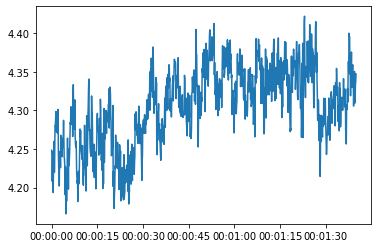

In [134]:
df_small = df[:1000]
plt.plot(df_small.BF1)

### Creating functions

Based off Kevin's `compute_corr.compute_correlation_time_scale.compute_autocorrelation_function()`

In [135]:
def compute_nd_acf(np_array, nlags, freq, show=False):
    """ Compute the autocorrelation function for a scalar or vector series.
    
    Args:

    - np_array: Array of shape (1,n) or (3,n)
    - freq: Frequency in Hertz

    Returns:

    - 

    """
    if np_array.shape[0] == 3:
        acf = \
        sm.tsa.acf(np_array[0], fft=False, nlags=nlags) + \
        sm.tsa.acf(np_array[1], fft=False, nlags=nlags) + \
        sm.tsa.acf(np_array[2], fft=False, nlags=nlags)
        acf /= 3

    elif np_array.shape[0] == 1:
        acf = sm.tsa.acf(np_array[0], fft=False, nlags=nlags)

    else:
        raise ValueError("Array is not 3D or 1D. If after a 1D acf, try putting square brackets around the pandas series in np.array()")

    time_lags = np.arange(0, nlags+1) / freq    

    if show == True:
        plt.plot(acf)
        plt.title("Autocorrelation")

    return time_lags, acf

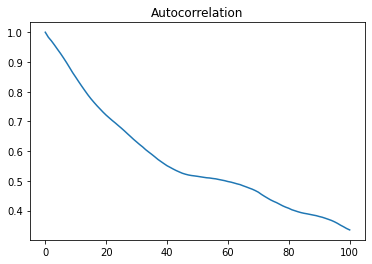

In [136]:
time_lags, vec_acf = compute_nd_acf(np.array([df_small.BGSE_0, df_small.BGSE_1, df_small.BGSE_2]), nlags=100, freq = 0.1, show = True)

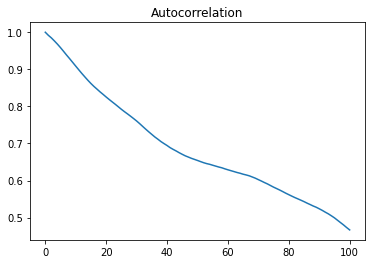

In [151]:
time_lags, scalar_acf = compute_nd_acf(np.array([df_small.BGSE_0]), nlags=100, freq = 0.1, show = True)

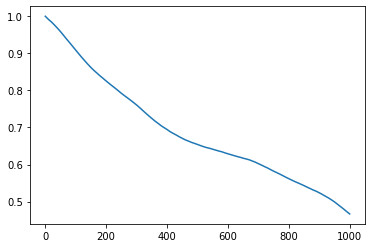

In [152]:
plt.plot(time_lags, scalar_acf)

Using Kevin's function for computing outer scale using $1/e$ trick

In [159]:
from utils import estimate_correlation_scale as compute_outer_scale_exp_trick, exp_fit

lambda_outer_exp_trick = compute_outer_scale_exp_trick(time_lags, vec_acf)

[937.27924418]


Adapting Kevin's function for computing outer scale using exponential fit: from `compute_correlation_time_scale()`

$$f(r)=\exp(-r/\lambda_c)$$

In [154]:
def compute_outer_scale_exp_fit(time_lags, acf, fit_seconds, freq, show = False):

    num_lags_for_lambda_c_fit = int(fit_seconds/freq)
    c_opt, c_cov = curve_fit(
        exp_fit, time_lags[:num_lags_for_lambda_c_fit], acf[:num_lags_for_lambda_c_fit], 1000) 
    lambda_c = c_opt[0]

    if show == True:
        ax = plt.gca()
        #ax.set_ylim(-.2, 1.2)
        plt.plot(time_lags, acf)
        plt.plot(
            np.array(range(int(fit_seconds))), 
            exp_fit(
                np.array(range(int(fit_seconds))),
                    *c_opt
                    ), 
                    'r-')
        box_color = 'grey' if lambda_c > 50 else 'red'
        ax.text(time_lags[-1]*(5/10), 0.9, f'lambda_c: {round(lambda_c, 1)} [sec]', style='italic', fontsize=10,
                bbox={'facecolor': box_color, 'alpha': 0.5, 'pad': 10})
        plt.show()

        print(f'correlation (time) scale: {round(lambda_c, 3)} [sec]')
    return round(lambda_c, 5)

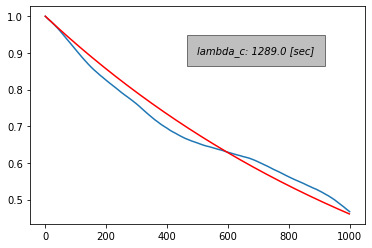

correlation (time) scale: 1289.031 [sec]


In [176]:
lambda_outer_exp_fit = compute_outer_scale_exp_fit(time_lags, scalar_acf, fit_seconds = 1000, freq = 0.1, show = True)

Creating function for computing outer scale as integral of the ACF

$$\lambda_C=\int_0^\infty R(\tau)d\tau$$

In [174]:
def compute_outer_scale_integral(acf, freq):
    # Compute the area using the composite trapezoidal rule.
    area = trapz(scalar_acf, dx=1/0.1)
    print("Area (trapz) =", area)

    # Compute the area using the composite Simpson's rule.
    area = simps(scalar_acf, dx=1/0.1)
    print("Area (simps) =", area)

In [175]:
compute_outer_scale_integral(scalar_acf, 0.1)

Area (trapz) = 689.2029793346534
Area (simps) = 689.2043274853434
